In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
f = open("tangentmaps/breast_cancer.tmap","r")
dataImport = json.loads(f.read())
tmap = dataImport['tmap']
Col_labels = dataImport['Col_labels']

data = dataImport

print(data['tmap'][0])
print(data['Col_labels'])

{'domain': [0.521, 0.023, 0.546, 0.364, 0.594, 0.792, 0.703, 0.731, 0.686, 0.606, 0.356, 0.12, 0.369, 0.274, 0.159, 0.351, 0.136, 0.301, 0.312, 0.183, 0.621, 0.142, 0.668, 0.451, 0.601, 0.619, 0.569, 0.912, 0.598, 0.419], 'range': [-39.446322685831284, 40.613091835571176], 'tangent': [[-0.03647778928279877, -0.046828851103782654, -0.04844680428504944, -0.03900071606040001, -0.07662012428045273, -0.08392611145973206, -0.20978417992591858, -0.10251053422689438, -0.005023688077926636, -0.0768919289112091, 0.05004710331559181, -0.06701255589723587, 0.005739636719226837, 0.0321219339966774, 0.033375099301338196, 0.009720072150230408, -0.03774528205394745, 0.05143999680876732, -0.04119078814983368, 0.043721213936805725, -0.03978017717599869, -0.10963039845228195, -0.0678500086069107, -0.03532823547720909, -0.05441371351480484, -0.06264539062976837, -0.20319949090480804, -0.07470269501209259, -0.04210353642702103, 0.000425487756729126], [0.30164116621017456, 0.19392237067222595, 0.29641985893

# Vector Field

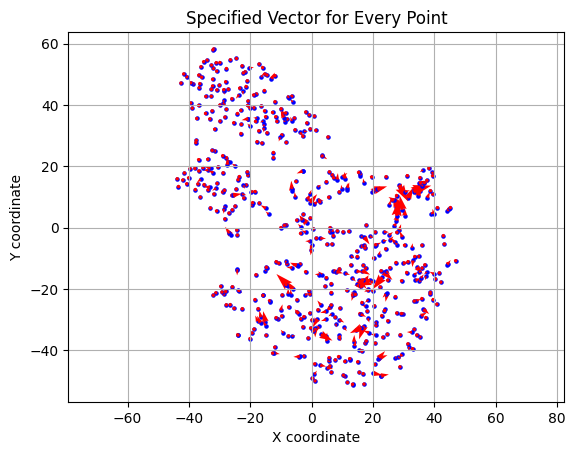

In [25]:
with open("tangentmaps/breast_cancer.tmap", "r") as f:
    data = json.load(f)

vector_index = 1

px_list = []
py_list = []
vx_list = []
vy_list = []

plt.figure()

for item in data["tmap"]:
    px, py = item["range"][0], item["range"][1]
    vx = item["tangent"][0][vector_index]
    vy = item["tangent"][1][vector_index]

    plt.scatter(px, py, color='blue', s=5)
    plt.quiver(px, py, vx, vy, angles='xy', scale_units='xy', scale=1, color='red')

    px_list.append(item["range"][0])
    py_list.append(item["range"][1])
    vx_list.append(item["tangent"][0][vector_index])
    vy_list.append(item["tangent"][1][vector_index])

plt.title("Specified Vector for Every Point")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.axis('equal')
plt.show()

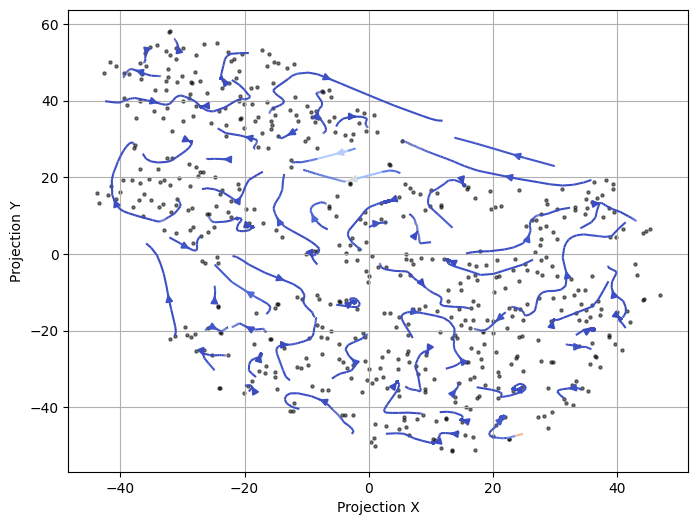

In [26]:
from scipy.interpolate import griddata

# Define a uniform grid
grid_x, grid_y = np.meshgrid(np.linspace(-80, 80, 500), np.linspace(-80, 80, 500))

# Interpolate feature vectors onto the grid
grid_gx = griddata((px_list, py_list), vx_list, (grid_x, grid_y), method='cubic')
grid_gy = griddata((px_list, py_list), vy_list, (grid_x, grid_y), method='cubic')

# Plot the feature map with streamlines
plt.figure(figsize=(8, 6))
plt.streamplot(grid_x, grid_y, grid_gx, grid_gy, density=1, color=np.hypot(grid_gx, grid_gy), cmap='coolwarm')
# plt.scatter(grid_x, grid_y, s=5, c='blue', alpha=0.3, label='Grid Points')
plt.scatter(px_list, py_list, c='black', s=5, alpha=0.5)
# plt.quiver(v_x, v_y, g_x, g_y, color='red', scale=10)
plt.grid(True)
plt.xlabel("Projection X")
plt.ylabel("Projection Y")
# plt.colorbar(label="Feature Influence Magnitude")
plt.show()

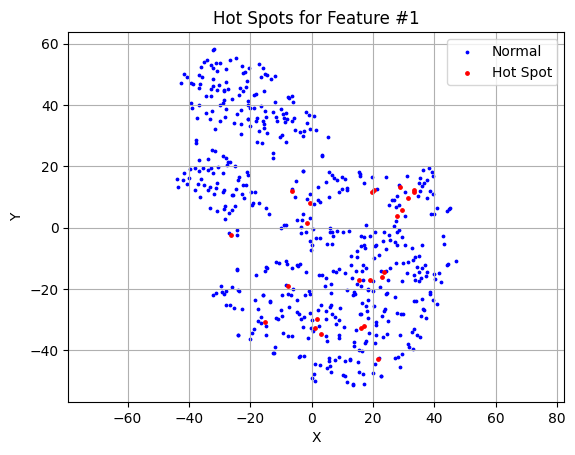

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import json

with open("tangentmaps/breast_cancer.tmap", "r") as f:
    data = json.load(f)

vector_index = 1
px_list, py_list, vx_list, vy_list = [], [], [], []

for item in data["tmap"]:
    px_list.append(item["range"][0])
    py_list.append(item["range"][1])
    vx_list.append(item["tangent"][0][vector_index])
    vy_list.append(item["tangent"][1][vector_index])

magnitudes = np.hypot(vx_list, vy_list)
threshold = np.mean(magnitudes) + 2 * np.std(magnitudes)

# Separate hot spots
hot_x = [px for px, mag in zip(px_list, magnitudes) if mag > threshold]
hot_y = [py for py, mag in zip(py_list, magnitudes) if mag > threshold]

normal_x = [px for px, mag in zip(px_list, magnitudes) if mag <= threshold]
normal_y = [py for py, mag in zip(py_list, magnitudes) if mag <= threshold]

plt.figure()
plt.scatter(normal_x, normal_y, color='blue', s=3, label='Normal')
plt.scatter(hot_x, hot_y, color='red', s=6, label='Hot Spot')
plt.legend()
plt.title("Hot Spots for Feature #{}".format(vector_index))
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis('equal')
plt.show()